In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from random import sample
from sklearn.model_selection import cross_val_score, KFold
from pandas import *
from sklearn.linear_model import LinearRegression
from scipy import stats
import seaborn as sns
import sys

In [3]:
# This is the place where your Capstone folder should be
main_path = os.getcwd()
print(main_path)

/Users/candide/Acads/Capstone


In [4]:
# I put my sp500.csv file inside a folder called data
symbols = pd.read_csv('sp500.csv')
print(symbols.head())

   Unnamed: 0 Symbol             GICS Sector
0           0    MMM             Industrials
1           1    ABT             Health Care
2           2   ABBV             Health Care
3           3   ABMD             Health Care
4           4    ACN  Information Technology


In [5]:
import glob
import pandas as pd

# get data file names - this is for windows (you might have to change the \\ to / with Linux/Mac)
path = main_path + '/data/'

filenames = glob.glob(path + "*.csv")
dfs = []
for filename in sorted(filenames):
    _= pd.read_csv(filename)
    _['Symbol']=filename.split('/')[-1].split('.')[0] #Maxime: I updated this part with the '\\' which is for Windows. You might have to change it back!
    _['Date'] = pd.to_datetime(_.Date)
    _ = _.sort_values(by=['Date']).reset_index(drop=True)
    dfs.append(_)

df_concat = pd.concat(dfs, ignore_index=True)
df_concat.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Symbol
0,1999-11-18,32.546494,35.765381,28.612303,31.473534,27.011942,62546300.0,A
1,1999-11-19,30.713520,30.758226,28.478184,28.880543,24.786524,15234100.0,A
2,1999-11-22,29.551144,31.473534,28.657009,31.473534,27.011942,6577800.0,A
3,1999-11-23,30.400572,31.205294,28.612303,28.612303,24.556314,5975600.0,A
4,1999-11-24,28.701717,29.998211,28.612303,29.372318,25.208586,4843200.0,A


In [6]:
df = df_concat.copy()
df.loc[df.Volume==0,['Open','High','Low','Close','Volume']]=np.nan

df['Open']  = df['Open'] /df['Close']*df['Adj Close']
df['High']  = df['High'] /df['Close']*df['Adj Close']
df['Low']   = df['Low']  /df['Close']*df['Adj Close']
df['Close'] = df['Close']/df['Close']*df['Adj Close']

for fwd_window in [5,10,20]:
    df['fwd_max_close'] = df.iloc[::-1].groupby('Symbol', sort=False).rolling(fwd_window, on='Close', min_periods=fwd_window).Close.max().iloc[::-1].reset_index(name='field')['field']
    df['fwd_min_close'] = df.iloc[::-1].groupby('Symbol', sort=False).rolling(fwd_window, on='Close', min_periods=fwd_window).Close.min().iloc[::-1].reset_index(name='field')['field']
    df['CPP'+str(fwd_window)] = 100*df['fwd_max_close']/df['Close']-100
    df['CPL'+str(fwd_window)] = 100*df['fwd_min_close']/df['Close']-100
    
    df['fwd_max_high']  = df.iloc[::-1].groupby('Symbol', sort=False).rolling(fwd_window, on='High', min_periods=fwd_window).High.max().iloc[::-1].reset_index(name='field')['field']
    df['fwd_min_low']   = df.iloc[::-1].groupby('Symbol', sort=False).rolling(fwd_window, on='Low',  min_periods=fwd_window).Low.min().iloc[::-1].reset_index(name='field')['field']
    df['PP'+str(fwd_window)] = 100*df['fwd_max_high']/df['Open']-100
    df['PL'+str(fwd_window)] = 100*df['fwd_min_low']/df['Open']-100
    df = df.drop(columns=['fwd_max_close','fwd_min_close','fwd_max_high','fwd_min_low'])

df = df[(df.Date<'2015-01-01')&(df.Date>='1990-01-01')]
df = df[~df.isnull()]

ind = list(df[(df['CPP20']>=10)&(df['CPP20']<=100)].index)
ind = sample(ind,len(ind))

In [7]:
df.drop(['Open', 'High', 'Low', 'Close'], axis=1, inplace=True)

In [8]:
log_values = np.logspace(0, 2, num=50) # 50 logarithmically spaced values between 1 and 100
b = np.unique([int(round(num-1)) for num in log_values])
X_data = []
X_data_complete = []
s_num=50000
bwd_window=100
for i in ind[:s_num]:
    time_series = df.loc[i-(bwd_window-1):i,:]['Adj Close'].values[::-1]
    s = df.loc[i-(bwd_window-1):i,:]['Symbol'].values
    y = df.loc[i-(bwd_window-1):i,:].index.values
    y = y[-1]-y[0]+1
    if np.sum(~np.isnan(time_series))==bwd_window and y==bwd_window and s[0]==s[-1]:
        data_complete = (time_series-np.mean(time_series))/np.std(time_series)
        x = time_series[b]
        data = (x-np.mean(time_series))/np.std(time_series)
        X_data.append(data)
        X_data_complete.append(data_complete)

In [9]:
X_data = np.array(X_data)
X_data_complete = np.array(X_data_complete)

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
X_data, X_data_complete = shuffle(X_data, X_data_complete, random_state=42)
print(X_data.shape, X_data_complete.shape)

(48687, 34) (48687, 100)


In [10]:
from sklearn.cluster import KMeans

clu = KMeans(n_clusters=10, random_state=0)
clu.fit(X_data)
labels1 = clu.labels_

### Plot the clustered time-series

In [11]:
tick_locations = np.arange(99, -1, -1)
tick_locations = tick_locations[b][::-1]

In [12]:
import matplotlib
%matplotlib inline

In [13]:
matplotlib.rc('xtick', labelsize=8) 

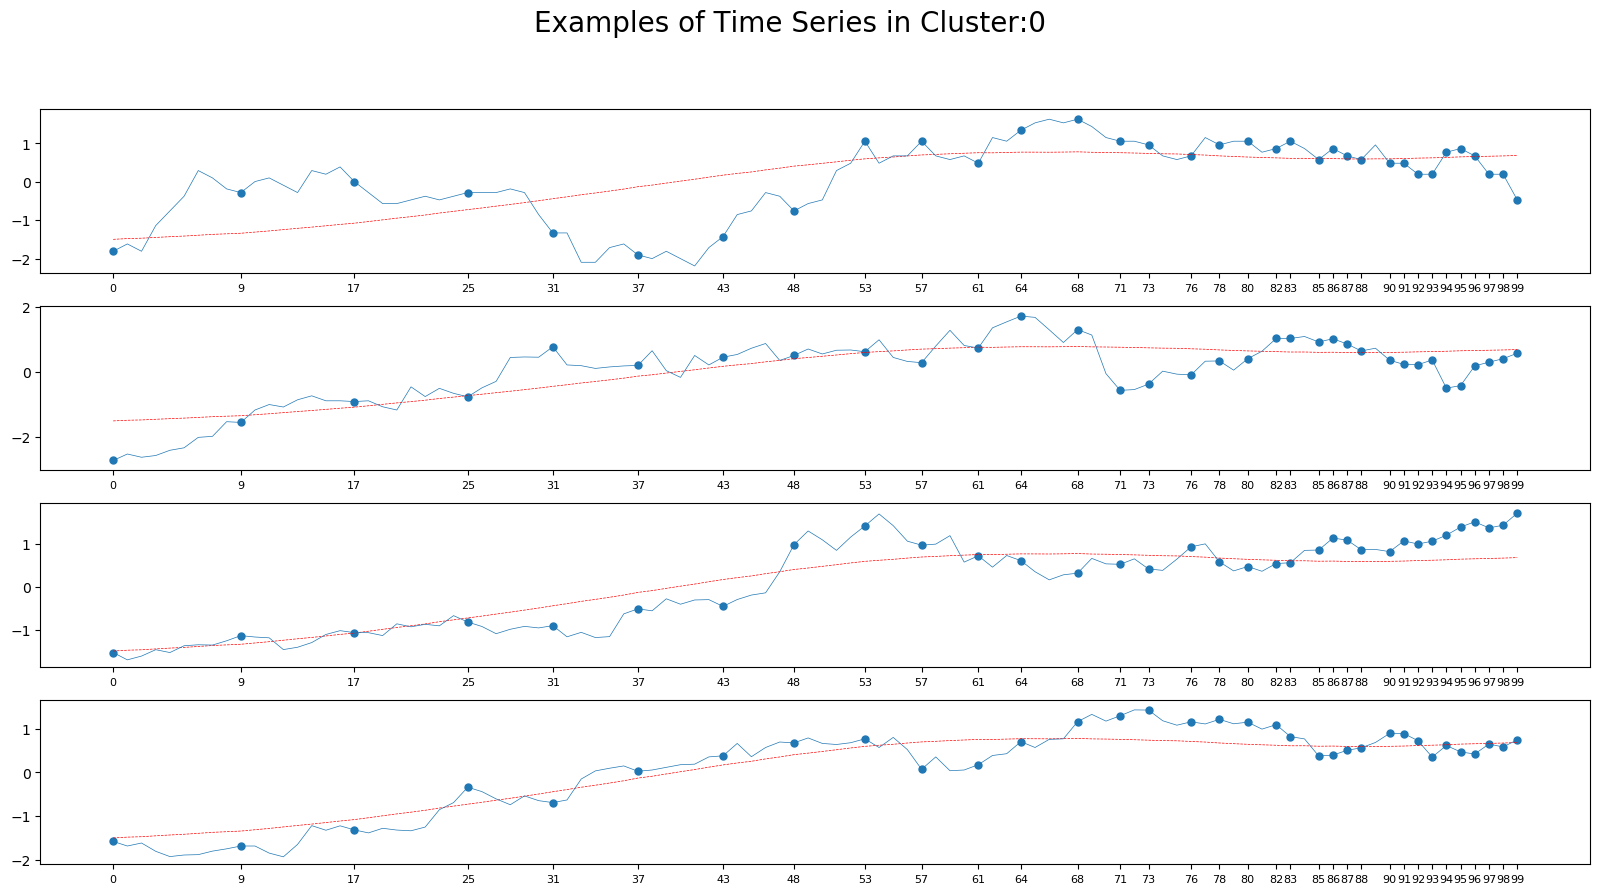

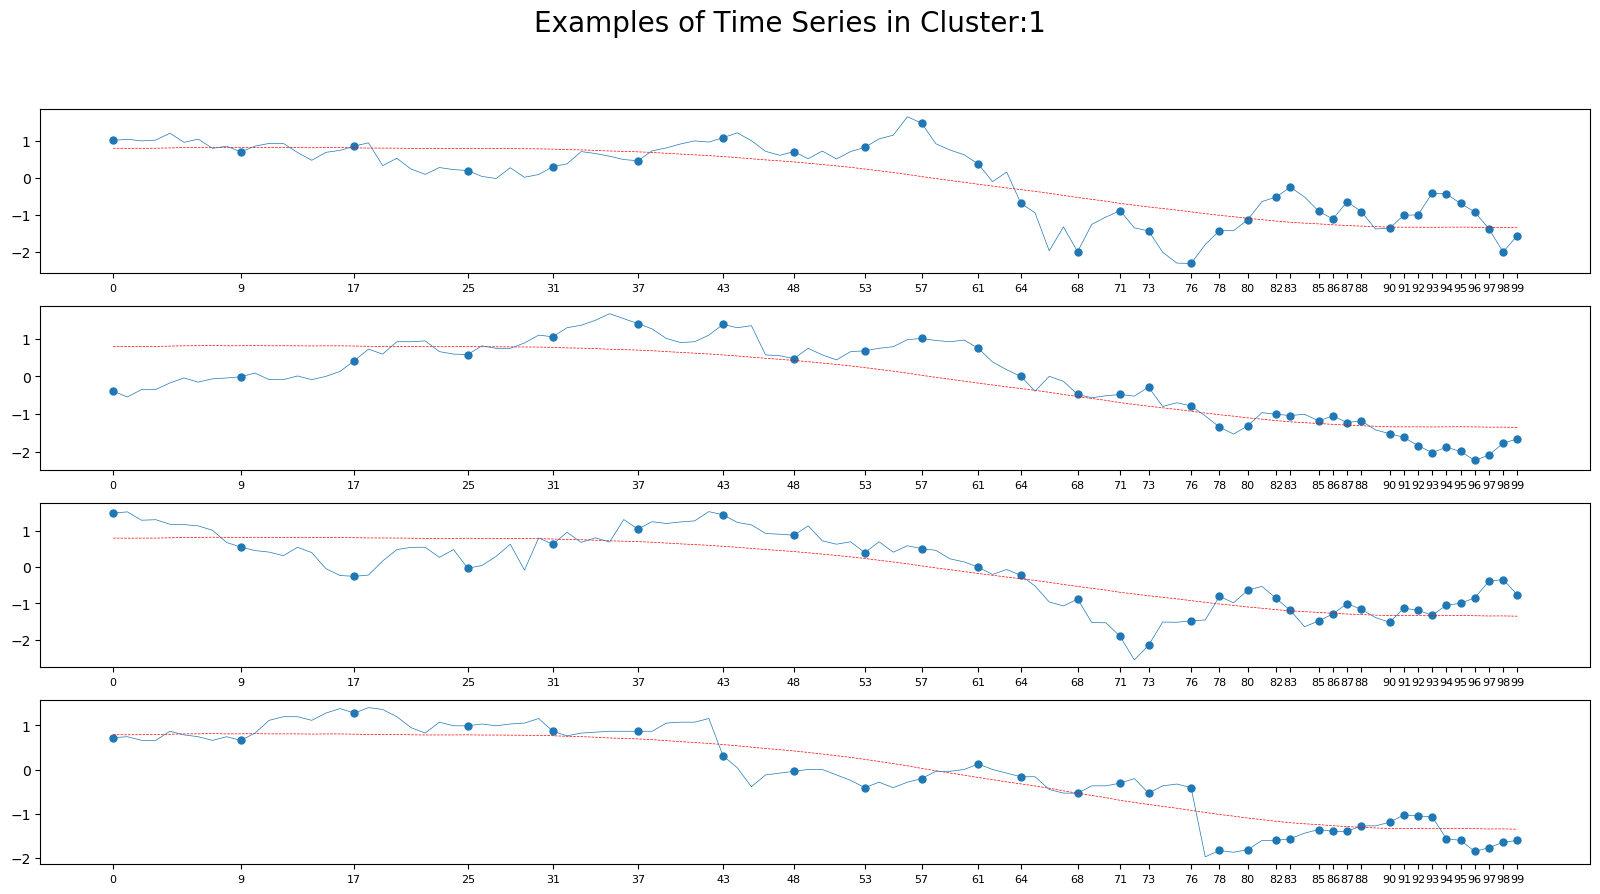

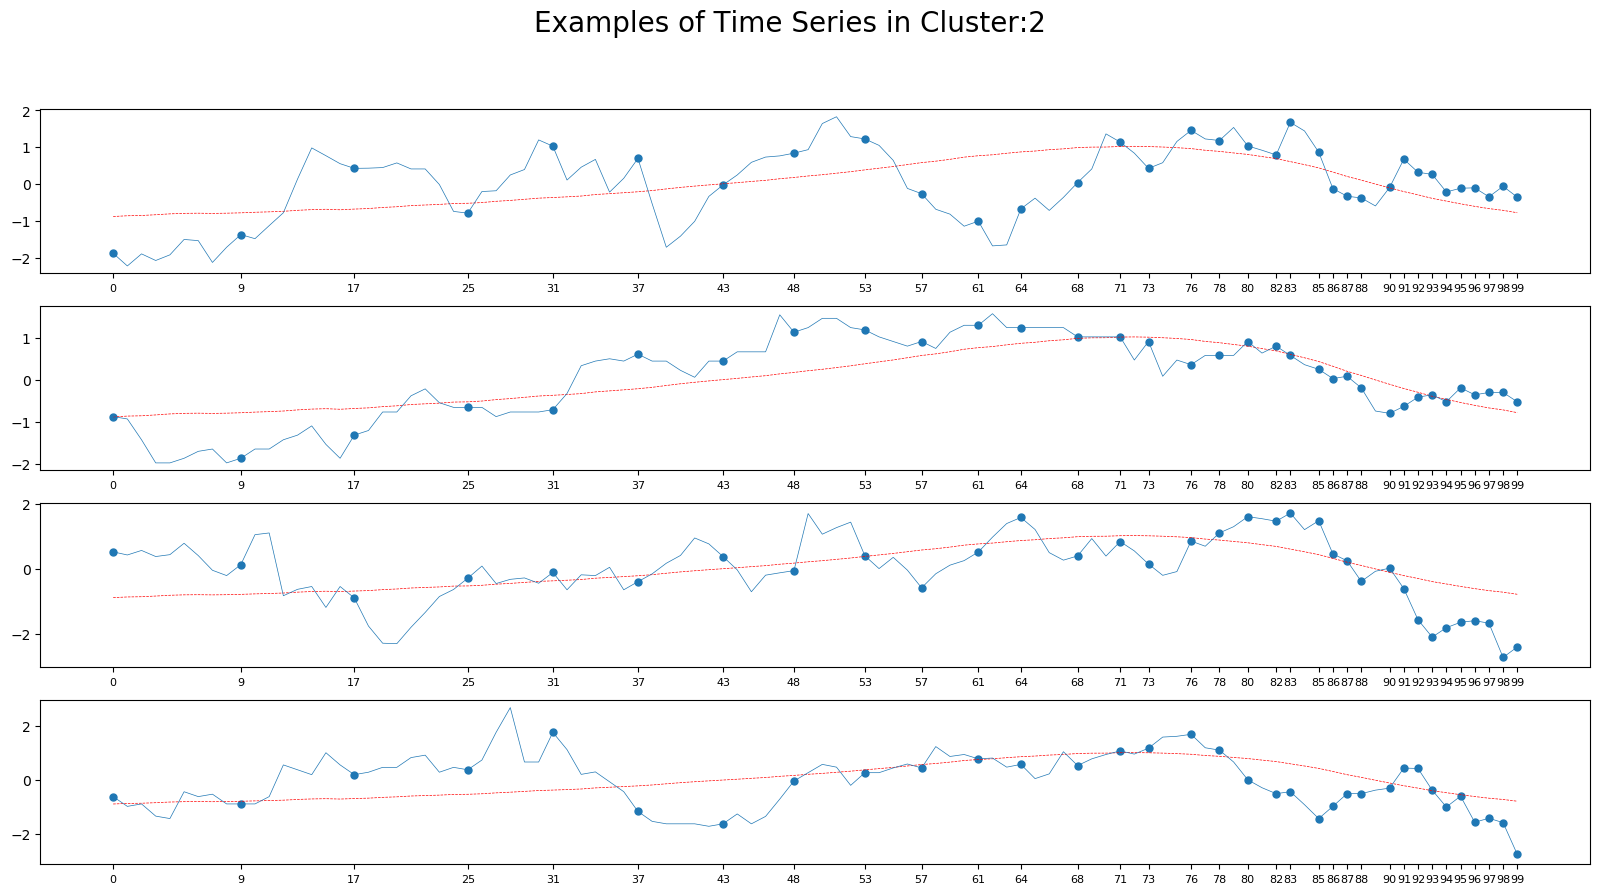

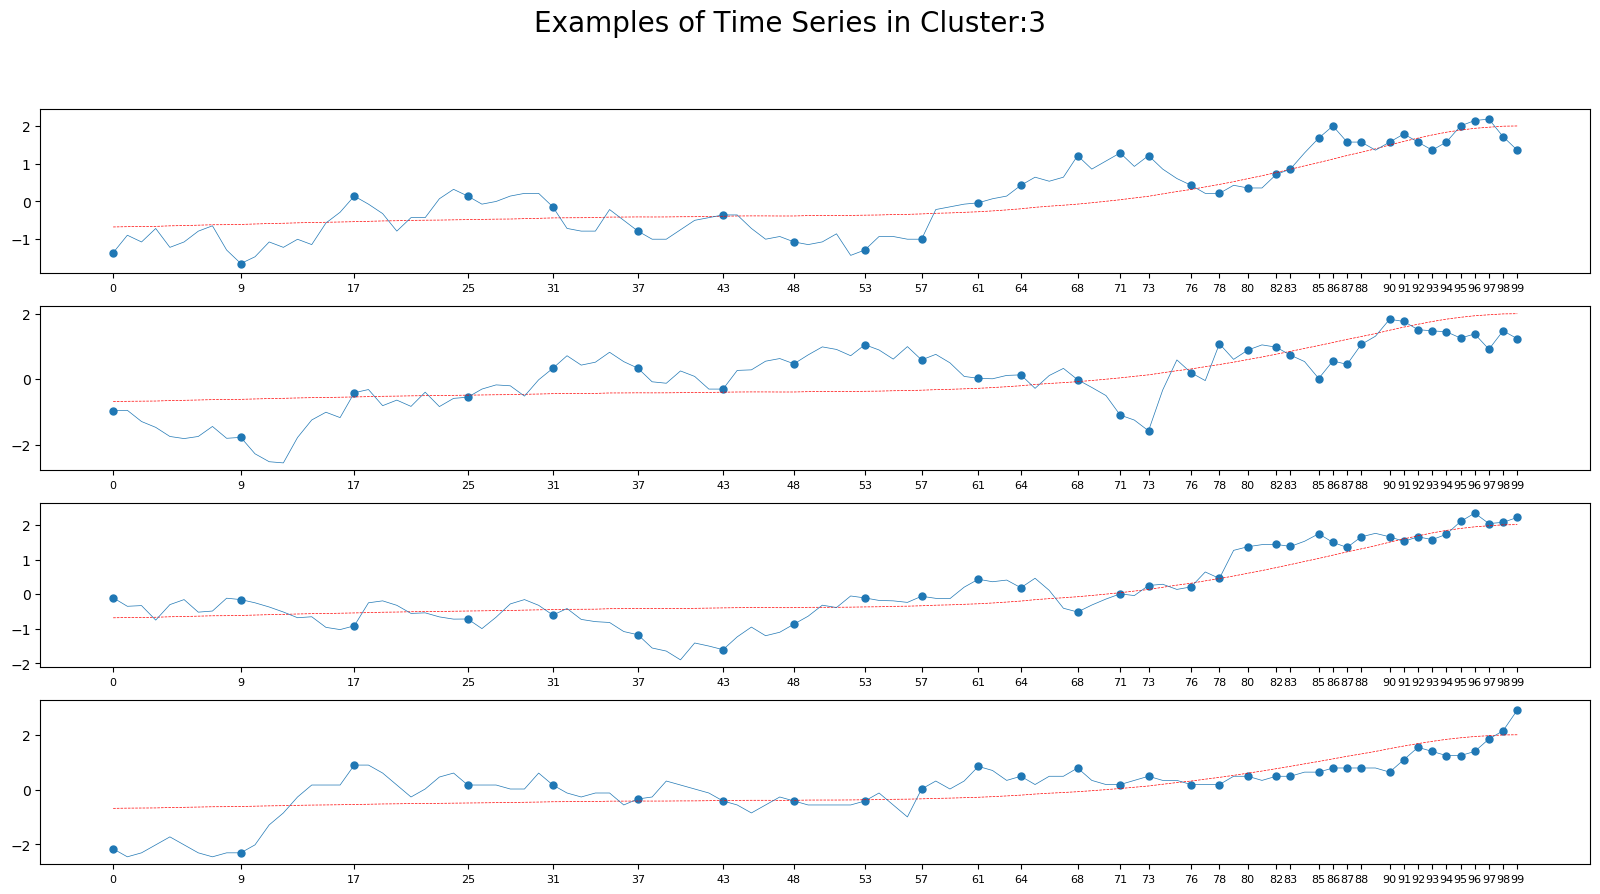

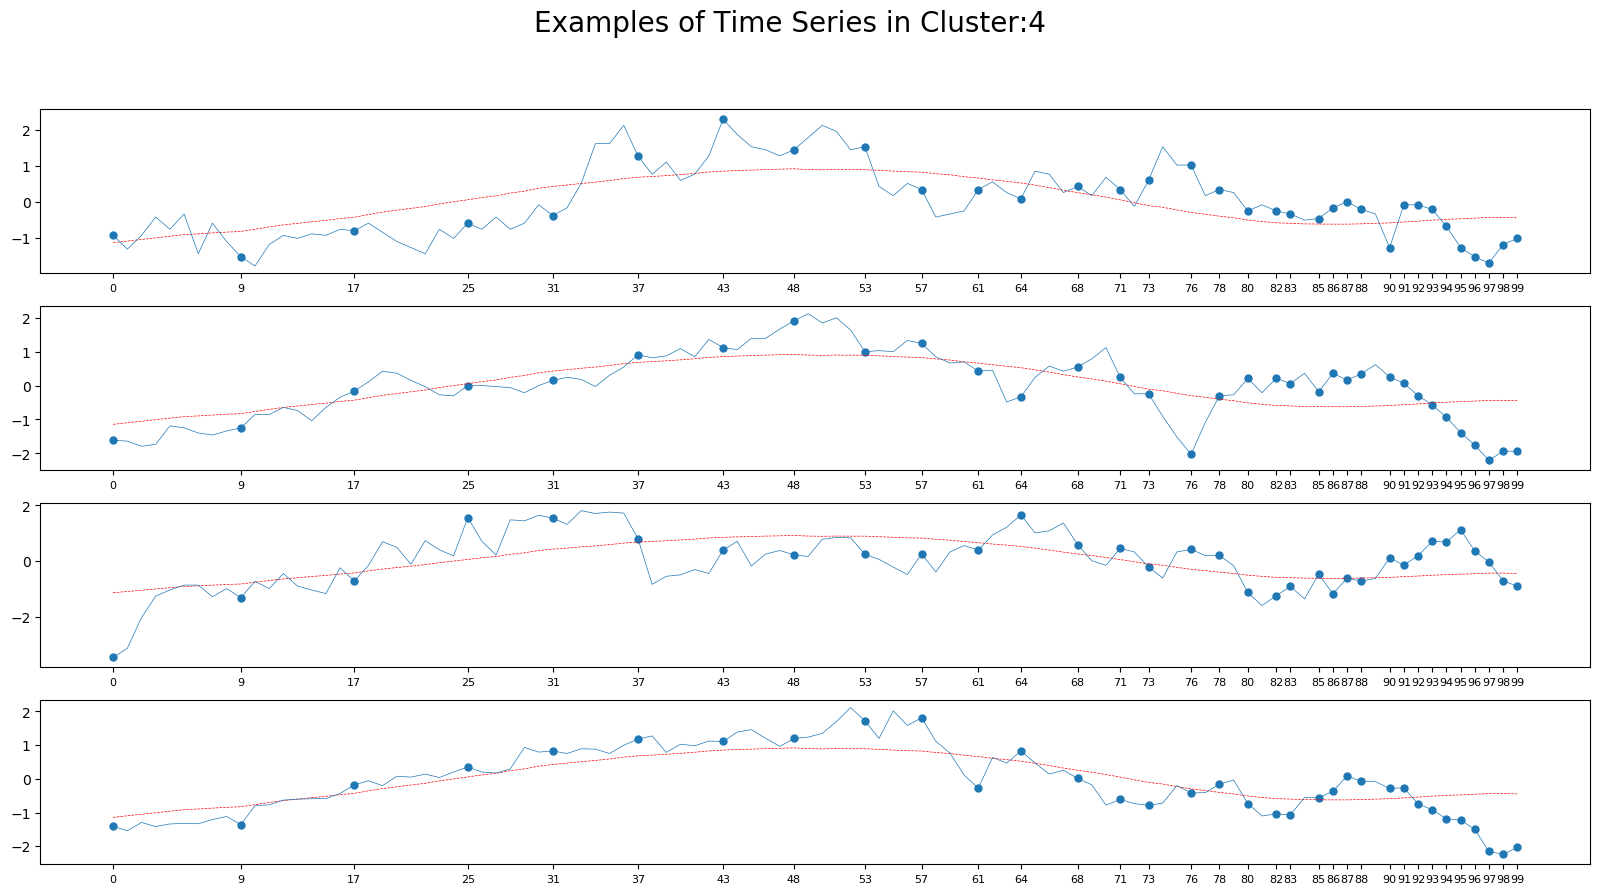

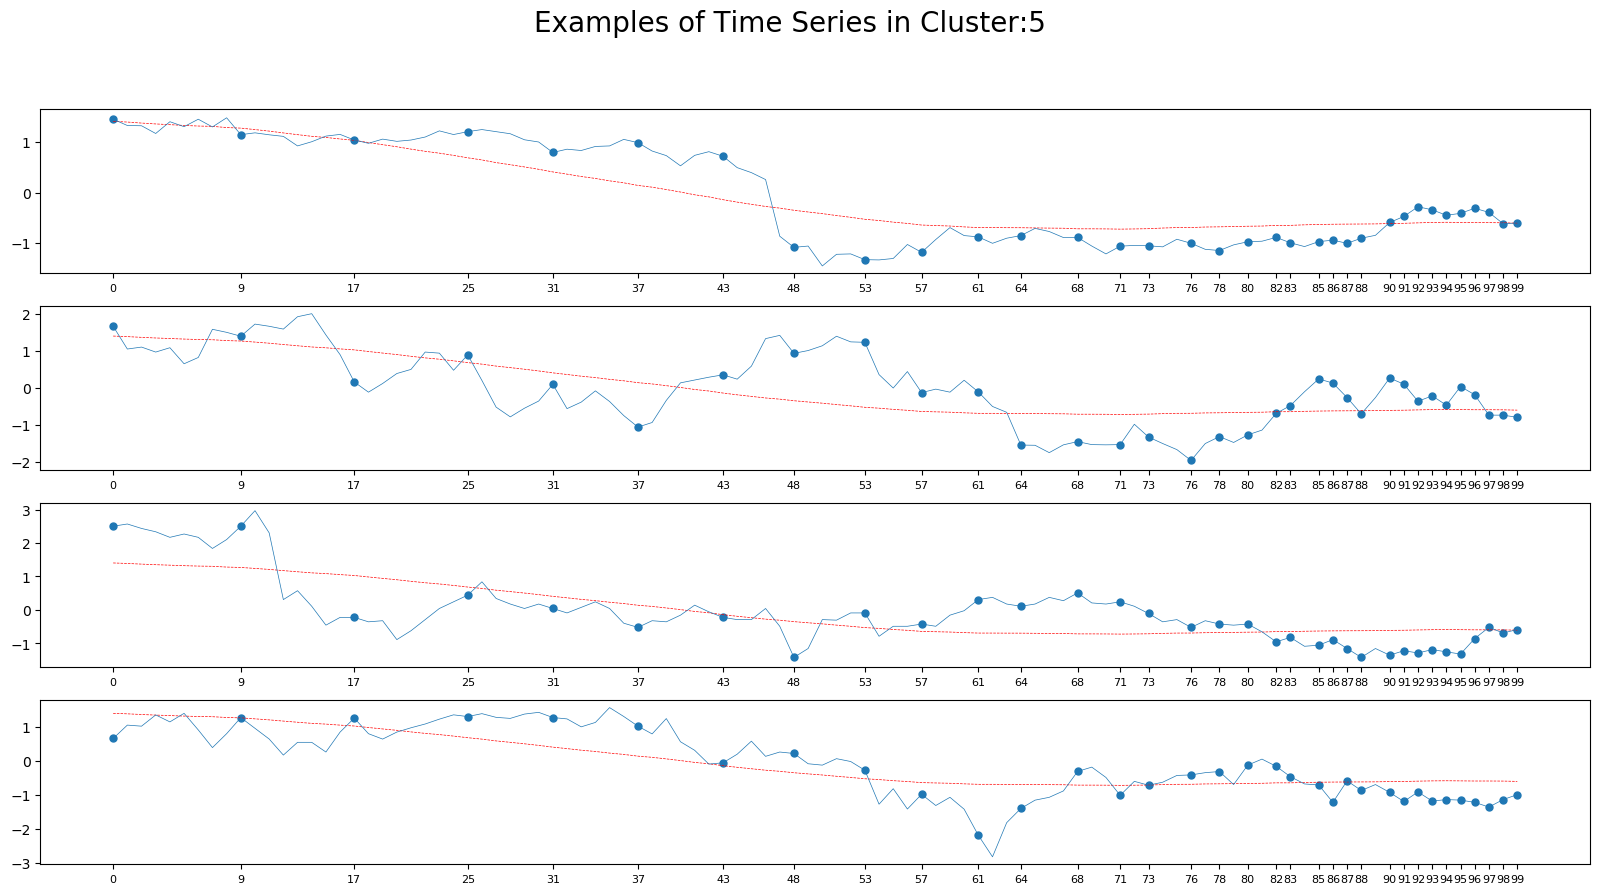

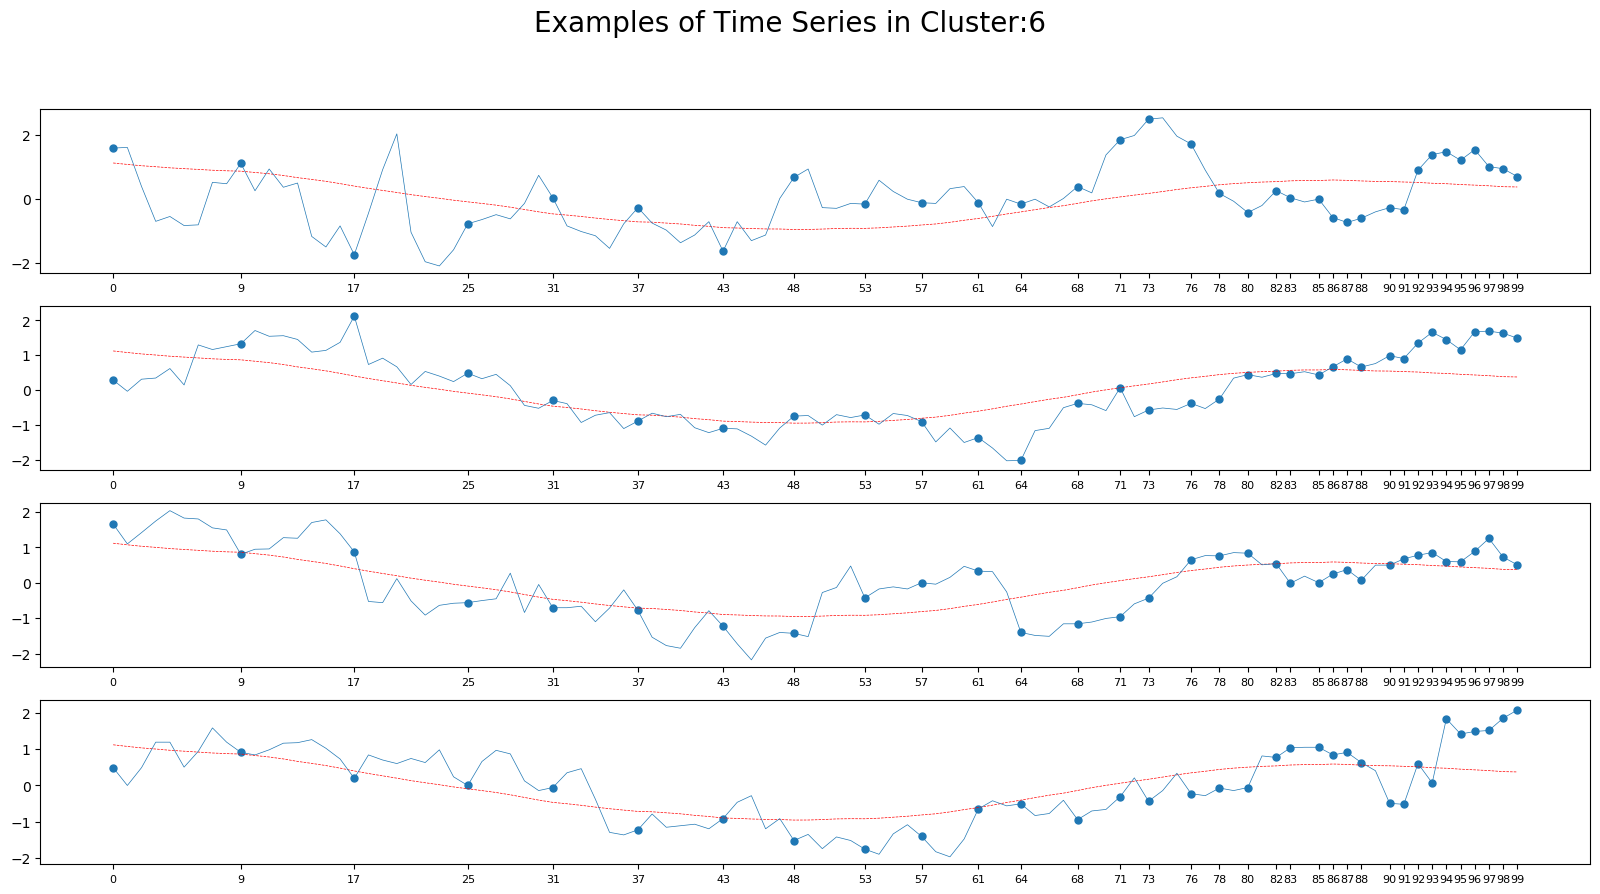

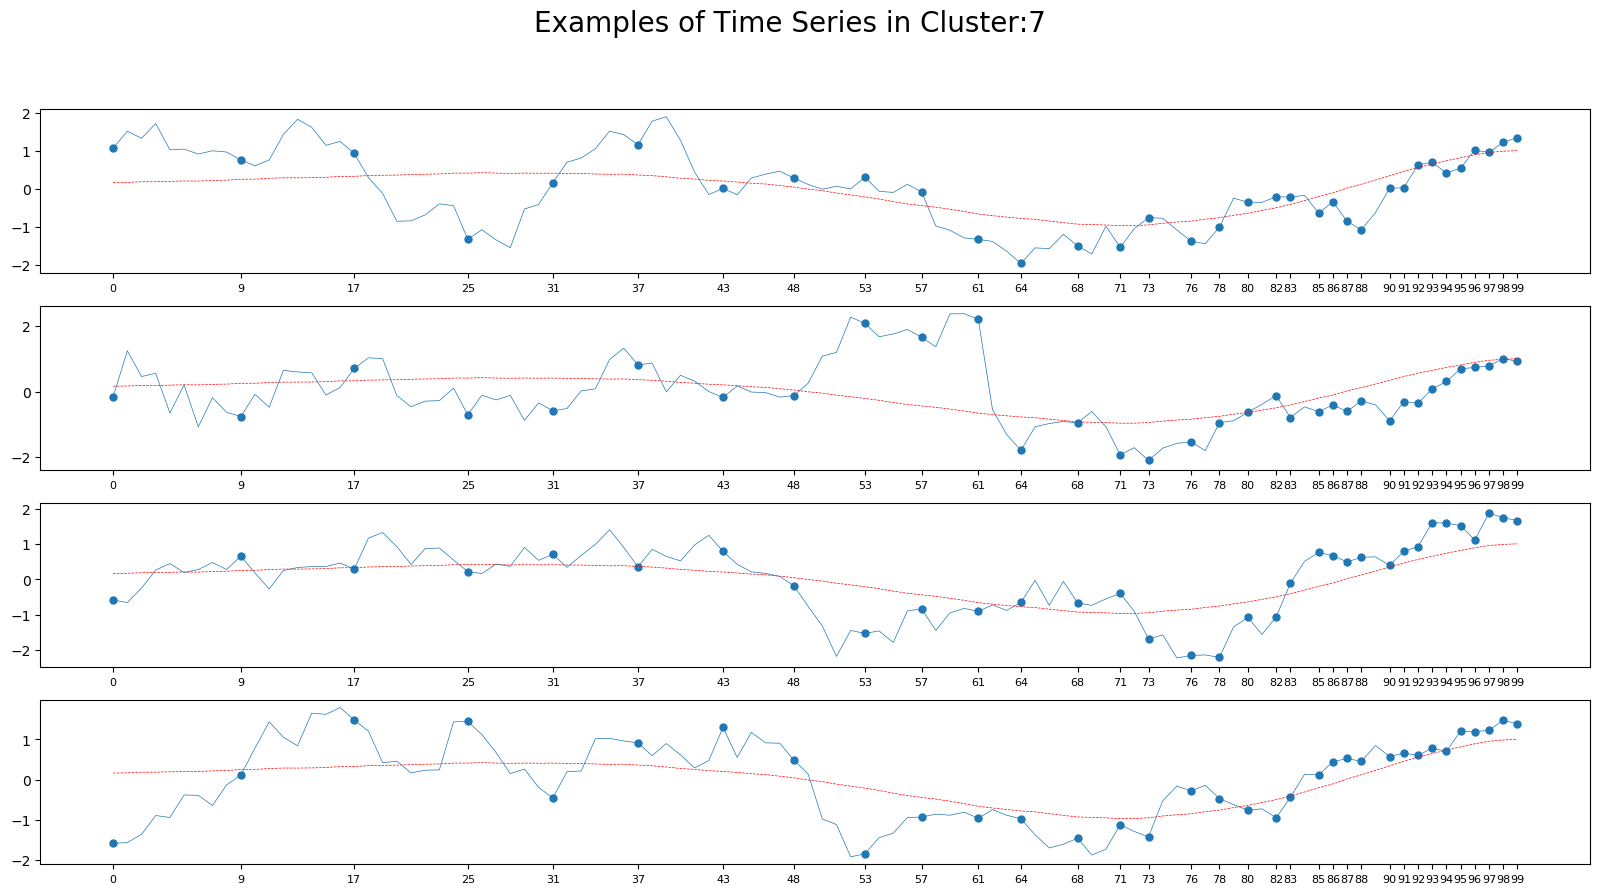

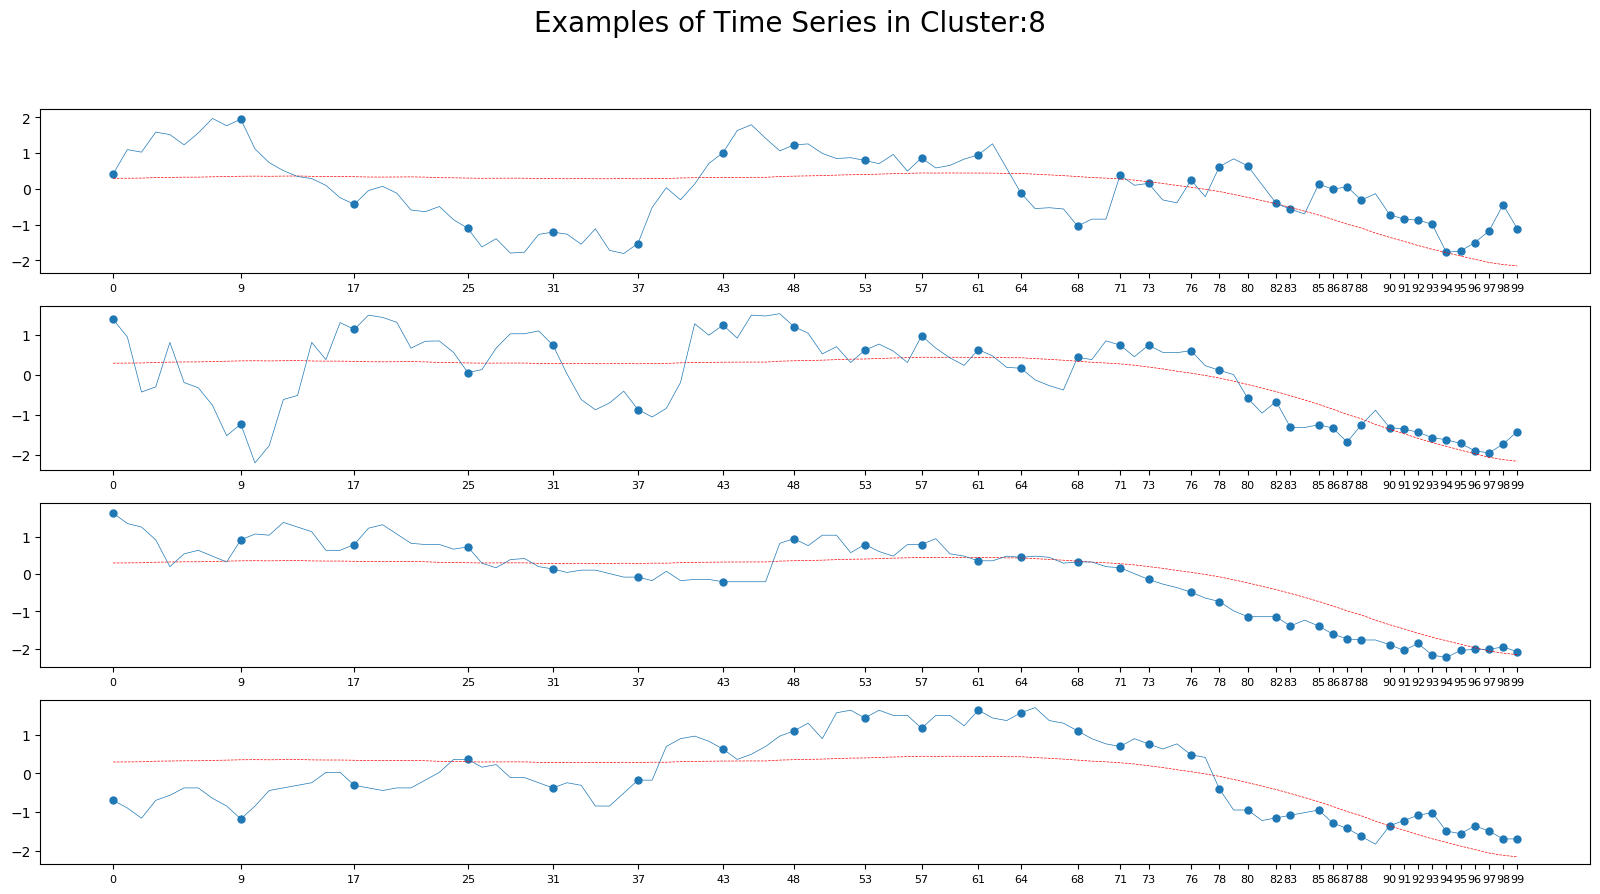

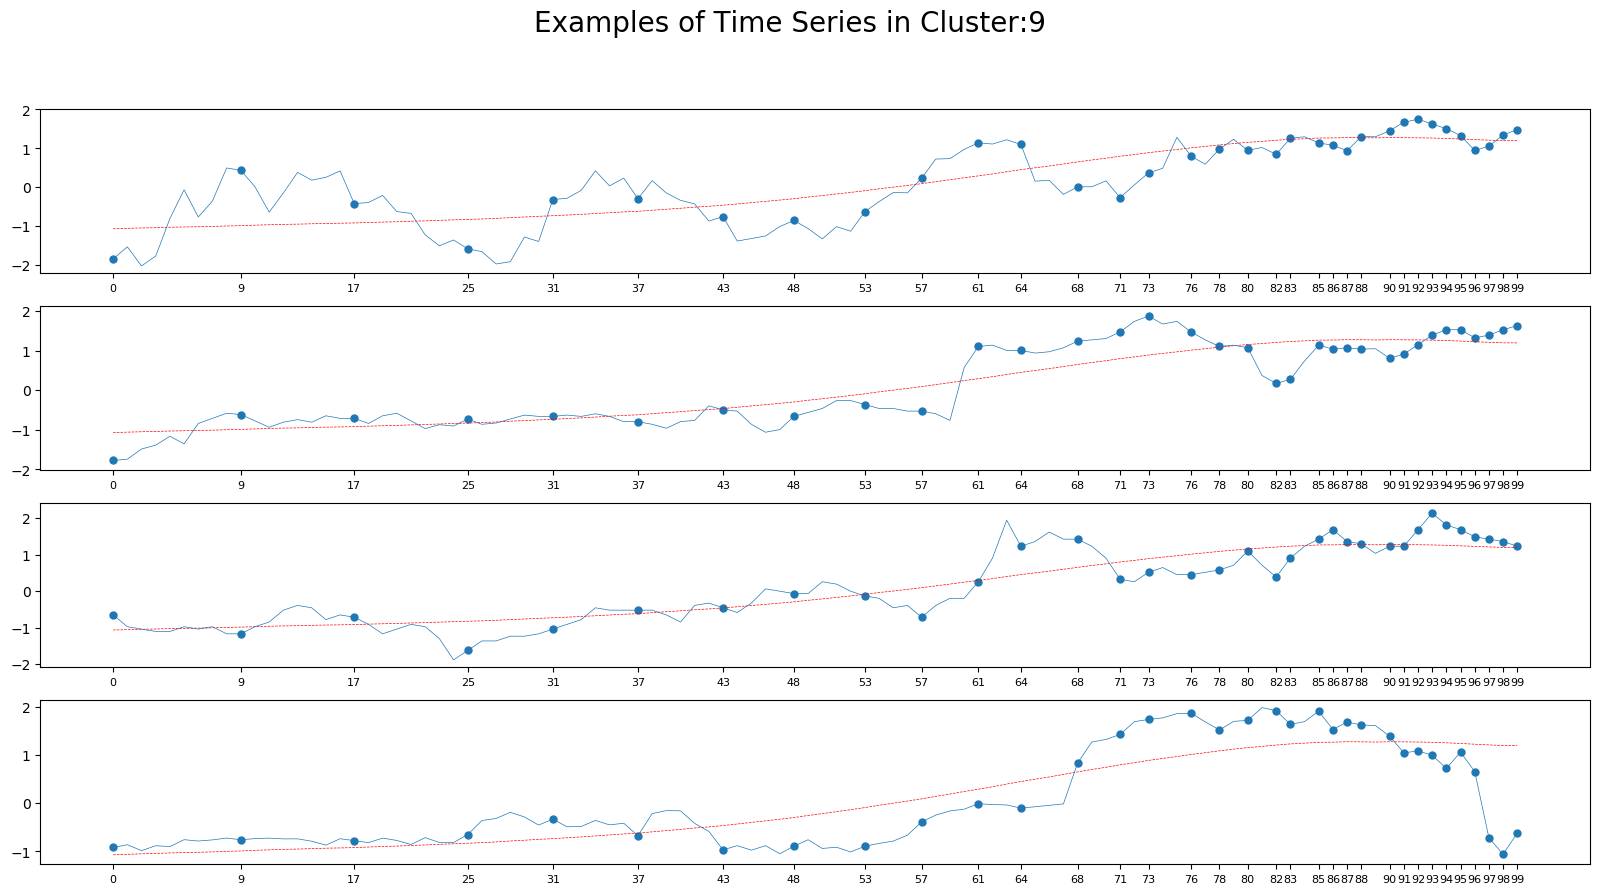

In [32]:
# We Look at the type of values that have been stored in cluster 1
for cluster_nb in range(10):
    indices = [i for i in range(len(labels1)) if labels1[i] == cluster_nb]
    mean_time_series = X_data_complete[indices].mean(0)
    fig, axes = plt.subplots(4, 1,figsize=(20,10), dpi=100)
    fig.suptitle('Examples of Time Series in Cluster:' + str(cluster_nb), fontsize=20)
    for i in range(4):
        axes[i].plot(mean_time_series[::-1], "r--", linewidth=0.5)
        axes[i].plot(X_data_complete[indices[i]][::-1], linewidth=0.5)
        axes[i].scatter(tick_locations, X_data[indices[i]][::-1], s=25)
        axes[i].set_xticks(ticks=tick_locations)
    plt.show()
    fig.savefig("log_spaced_timeseries_kmeans_" + str(cluster_nb) + ".png", dpi=200)